In [87]:
import Bio
import operator
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna, generic_protein, generic_rna
from Bio.Blast import NCBIWWW
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import SeqIO
from Bio import pairwise2
from chembl_webresource_client.new_client import new_client

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import py3Dmol

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

amino_acids_mapping = {v: k for k, v in Bio.SeqUtils.IUPACData.protein_letters_3to1.items()}

In [104]:
# Read DNA data
cov2 = SeqIO.read('cov2.fasta', "fasta")
sars = SeqIO.read('sars.fasta', "fasta")
mers = SeqIO.read('mers.fasta', "fasta")

In [105]:
print(f"Cov2 DNA length: {len(cov2)}")
print(f"Sars DNA length: {len(sars)}")
print(f"Mers DNA length: {len(mers)}")

Cov2 DNA length: 29903
Sars DNA length: 29751
Mers DNA length: 30119


In [4]:
SARS_COV = pairwise2.align.globalxx(sars.seq, cov2.seq, one_alignment_only=True, score_only=True)
MERS_COV = pairwise2.align.globalxx(mers.seq, cov2.seq, one_alignment_only=True, score_only=True)
MERS_SARS = pairwise2.align.globalxx(mers.seq, sars.seq, one_alignment_only=True, score_only=True)

X = ['Sars-Cov2', 'Mers-Cov2', 'Mers-Sars']
Y = [SARS_COV/ len(sars.seq) * 100, MERS_COV/ len(mers.seq)*100, MERS_SARS/len(sars.seq)*100]

In [106]:
def transcribe(DNA):
    return DNA.transcribe()

In [107]:
def RNA_to_DNA(RNA):
    if 'Bio.Seq.Seq' not in str(type(RNA)):
        RNA = Seq(RNA, generic_rna)
        
    return RNA.back_transcribe()

In [108]:
# Get all proteins that contain more than 20 amino acids from an RNA messenger
def get_amino_acids(mRNA):
    proteins = mRNA.translate()
    amino_acids = ''
    
    for protein in proteins.split('*'):
        if len(protein) > 20:
            amino_acids += protein + '*'
            
    return amino_acids

In [109]:
# Convert DNA's to RNA's
cov2 = transcribe(cov2.seq)
sars = transcribe(sars.seq)
mers = transcribe(mers.seq)

In [110]:
# Get all amino acids
cov2_acids = get_amino_acids(cov2)
sars_acids = get_amino_acids(sars)
mers_acids = get_amino_acids(mers)

In [111]:
def update_table(t, l):
    for k in l:
        if k in t:
            t[k] += l[k]
        else:
            t[k] = l[k]
    return t

In [112]:
def get_acid_counter(seq):
    counter = {}

    for protein in seq.split('*'):
        X = ProteinAnalysis(str(protein))
        POI = X.count_amino_acids()
        counter = update_table(counter, POI)
        
    return counter, sorted(counter, key=counter.get, reverse=True)[:4]

In [12]:
cov2_protein_counter, cov2_protein_highest = get_acid_counter(cov2_acids)

<BarContainer object of 20 artists>

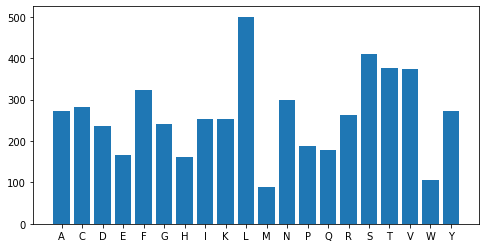

In [113]:
plt.figure(figsize=(8,4));
plt.bar(cov2_protein_counter.keys(), list(cov2_protein_counter.values()), align='center')

<BarContainer object of 3 artists>

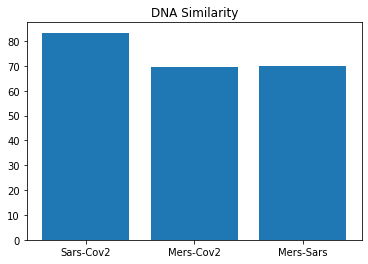

In [114]:
plt.title('DNA Similarity')
plt.bar(X,Y)

In [115]:
def getMostFreqMolecules(x):
    covid_acids = []
    covid_mole_struc = []

    for p in x:
        try:
            acid = amino_acids_mapping[p]

            # create a new molecule
            molecule = new_client.molecule
            molecule_chembl_id = molecule.search(acid)[0]['molecule_chembl_id']

            res = molecule.get(molecule_chembl_id)
            # return smile format molecular structure
            smileStruct = res['molecule_structures']['canonical_smiles']

            m = Chem.MolFromSmiles(smileStruct)
            m = Chem.AddHs(m)
            
            covid_acids.append(acid)
            covid_mole_struc.append(m)
        except:
            print('err')
            
    return covid_acids, covid_mole_struc

In [116]:
# Get the most frequent molecules found in covid19
covid_acids, covid_mole_struc = getMostFreqMolecules(cov2_protein_highest)

In [123]:
print('Get the most frequent molecules found in covid19')
for i in range(len(covid_acids)):
    print(f'{i}: {covid_acids[i]}')

Get the most frequent molecules found in covid19
0: Leu
1: Ser
2: Thr
3: Val


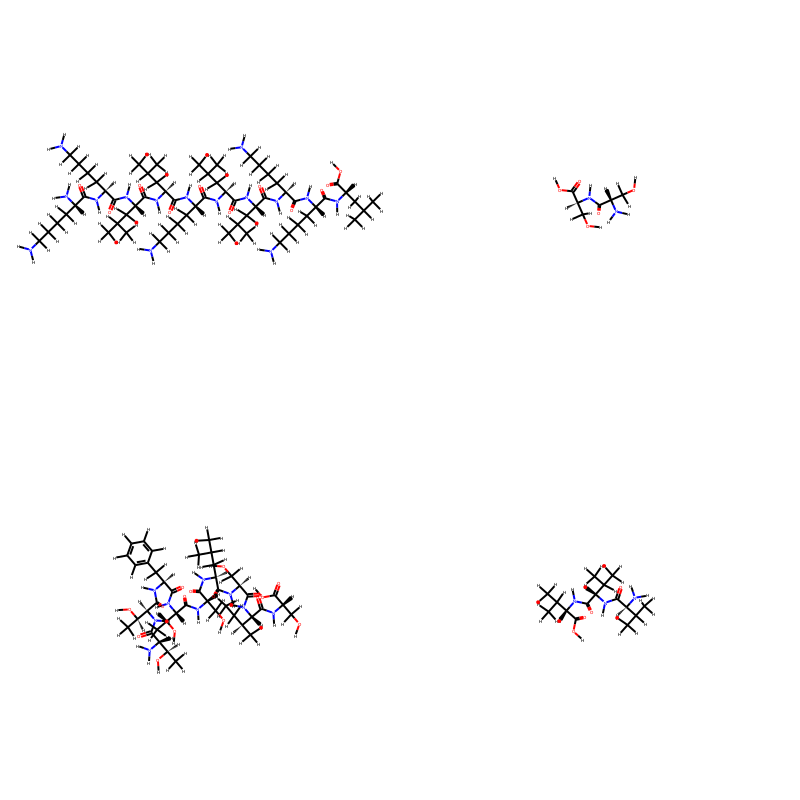

In [122]:
Draw.MolsToGridImage(covid_mole_struc, molsPerRow=2, maxMols=50, subImgSize=(400,400))